# Deep Learning
## Practice Projects
# P2: Image Generation

## Step 0. Style and Libraries

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

Using TensorFlow backend.


## Step 1. Load and Explore the Data
Run the following cell to download the dataset.

In [5]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/" + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("data/letters.csv")
files = data['file']
letters = data['letter']
targets = data['label'].as_matrix()
tensors = data_to_tensor(files);

100%|██████████| 726/726 [00:00<00:00, 1092.46it/s]


In [6]:
hide_code
# Print the shape 
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (726, 32, 32, 3)
Target shape (726,)


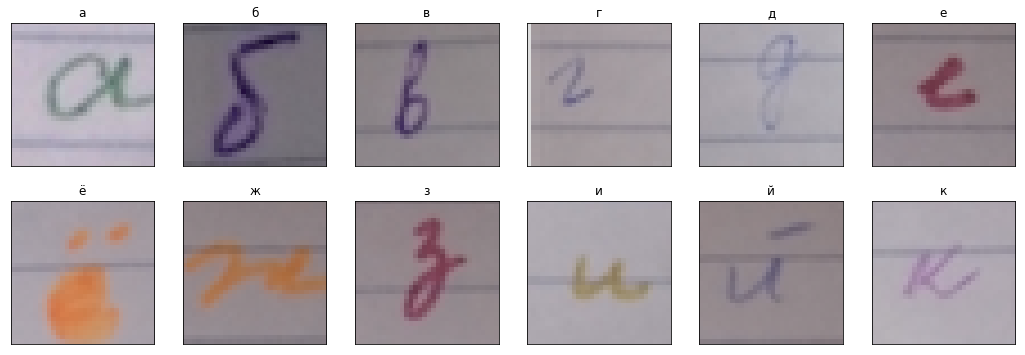

In [18]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*22])
    display_images(files[i*22], ax)

## Step 2. Save and Load the Data¶
The data tensors can be saved in the appropriate format of files .h5.

In [21]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.close()

In [22]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['images', 'labels']

In [24]:
hide_code
# Create tensors and targets
tensors = np.array(f[keys[0]])
targets = np.array(f[keys[1]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (726, 32, 32, 3)
Target shape (726,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [32]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

Create tensors of grayscaled images and display their shape.

In [38]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (726, 32, 32)


Label:  д


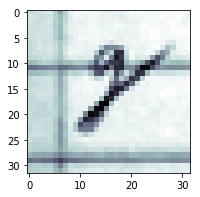

In [39]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[100], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [52]:
hide_code
# Print the target unique values
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [53]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(726, 33)

### Split
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 10%.

In [54]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.1, 
                                                    random_state = 1)

In [55]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.1, 
                                                        random_state = 1)

Let's pring the shape of these data sets.

In [56]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (653, 32, 32, 3)
Training target's shape (653, 33)
Testing tensor's shape: (73, 32, 32, 3)
Testing target's shape (73, 33)


## Step 4. Create a Model
Define a model architecture and compile the model.